In [1]:
import sys
sys.path.insert(1, '../../..')

In [2]:
import re
import numpy as np
import pandas as pd
from medicine.models.compound import Compound
from medicine.models.medicine import Medicine
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
compound_id = []
compound_name = []
compound_list = []

for compound in Compound.query.all():
    compound_id.append(compound.id)
    compound_name.append(compound.name)
    medicine_list = [medicine.name for medicine in compound.medicine]
    compound_list.append(medicine_list)

F:\Python\anaconda3\lib\site-packages\sqlalchemy\engine\default.py:470: Warning: (1366, "Incorrect string value: '\\xA5x\\xA5_\\xBC\\xD0...' for column 'VARIABLE_VALUE' at row 480")
  cursor.execute(statement, parameters)


In [4]:
data_df = pd.DataFrame(data=[(compound.id, compound.name, compound.medicine) for compound in Compound.query.all()], 
                       columns=['id', 'cname', 'medicine'])
data_df.head(5)

,id,cname,medicine
0,1,滅瘢痕,"[Medicine('夏冰', '水')]"
1,2,闢禳時疫,"[Medicine('半天河', '水')]"
2,3,身體白駁,"[Medicine('半天河', '水')]"
3,4,目不得瞑,"[Medicine('流水', '水'), Medicine('半夏', '草')]"
4,5,汗後奔豚,"[Medicine('流水', '水'), Medicine('甘草', '草'), Med..."


In [5]:
data_df = data_df.set_index('id')

for index, row in data_df.iterrows():
    medicines = []
    for medicine in row.medicine:
        medicines.append(medicine.name)
    row.medicine = medicines
    
data_df.head(5)

,cname,medicine
id,,
1,滅瘢痕,[夏冰]
2,闢禳時疫,[半天河]
3,身體白駁,[半天河]
4,目不得瞑,"[流水, 半夏]"
5,汗後奔豚,"[流水, 甘草, 茯苓]"


### 嘗試用附方名稱分群

In [6]:
word_list = []

for index, row in data_df.iterrows():
    c_name = re.sub('(\s|KT)', '', row['cname'])
    sentences = re.split('\W', c_name)
    cut_word = []
    for sentence in sentences:
        cut_word.extend([word for word in sentence])
        cut_word.extend([sentence[i:i+2] for i in range(len(sentence)-1)])
    word_list.append(cut_word)

data_df['cut_name'] = word_list
data_df.head(5)

,cname,medicine,cut_name
id,,,
1,滅瘢痕,[夏冰],"[滅, 瘢, 痕, 滅瘢, 瘢痕]"
2,闢禳時疫,[半天河],"[闢, 禳, 時, 疫, 闢禳, 禳時, 時疫]"
3,身體白駁,[半天河],"[身, 體, 白, 駁, 身體, 體白, 白駁]"
4,目不得瞑,"[流水, 半夏]","[目, 不, 得, 瞑, 目不, 不得, 得瞑]"
5,汗後奔豚,"[流水, 甘草, 茯苓]","[汗, 後, 奔, 豚, 汗後, 後奔, 奔豚]"


In [7]:
te = TransactionEncoder()
te_ary = te.fit(data_df['cut_name']).transform(data_df['cut_name'])
df_name = pd.DataFrame(te_ary, columns=te.columns_)
print(df_name.shape)
df_name.head(5)

(5815, 9779)


,一,一二,一人,一分,一切,一升,一女,一字,一宿,一寸,...,龈風,龍,龍丸,龍症,龍纏,龍膽,龍香,龜,龜病,龜背
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Hierarchy cluster

In [8]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

In [9]:
Z = linkage(df_name, 'ward')
dist = pdist(df_name)

In [10]:
c, coph_dists = cophenet(Z, dist)

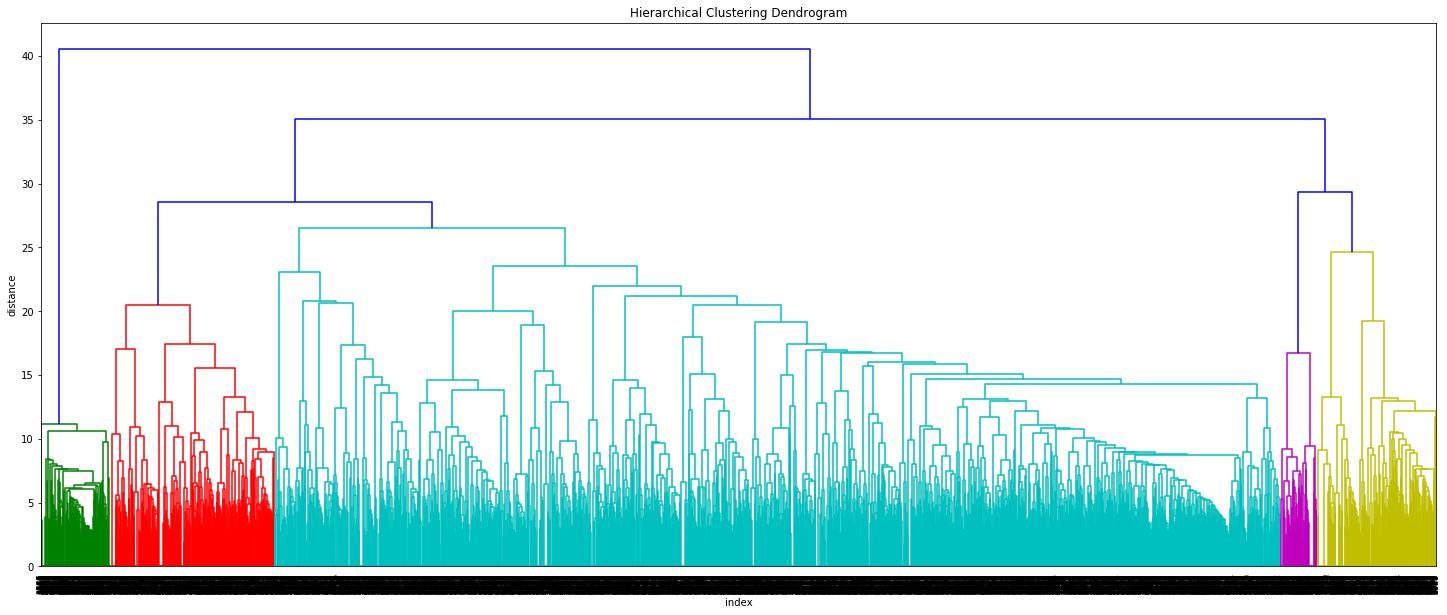

In [11]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

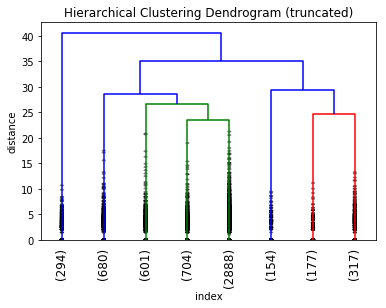

In [12]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    # show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [13]:
from sklearn import cluster, datasets, metrics
import matplotlib.pyplot as plt

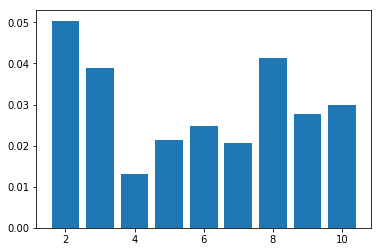

[0.05039948735129335, 0.038934488233390394, 0.013124506726694775, 0.021360470619997674, 0.024664814360290718, 0.020546176167010124, 0.04122645831192706, 0.027718493517286856, 0.029823750557263093]


In [14]:
silhouette_avgs = []
ks = range(2,11)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters=k, n_init=20, max_iter=1000).fit(df_name)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(df_name, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)
# 0.4465 0.045

### Decision 8 groups

In [30]:
n_clusters = 8
kmeans_fit = cluster.KMeans(n_clusters=n_clusters, n_init=50, max_iter=1000).fit(df_name)
cluster_labels = kmeans_fit.labels_
metrics.silhouette_score(df_name, cluster_labels)

0.03978657100812668

In [31]:
group_dict = {i: np.where(kmeans_fit.labels_ == i)[0]+1 for i in range(kmeans_fit.n_clusters)}

In [32]:
group_df = data_df.loc[group_dict[6],]
group_df.head(5)

,cname,medicine,cut_name,group
id,,,,
53,代指腫痛,[熱湯],"[代, 指, 腫, 痛, 代指, 指腫, 腫痛]",7
61,手指腫痛,[漿水],"[手, 指, 腫, 痛, 手指, 指腫, 腫痛]",7
65,肛門腫痛，欲作痔瘡,[磨刀水],"[肛, 門, 腫, 痛, 肛門, 門腫, 腫痛, 欲, 作, 痔, 瘡, 欲作, 作痔, 痔瘡]",7
87,代指腫痛,[白垩],"[代, 指, 腫, 痛, 代指, 指腫, 腫痛]",7
96,内痔痛腫,"[黃土, 朴硝, 黃連, 人屎]","[内, 痔, 痛, 腫, 内痔, 痔痛, 痛腫]",7


In [33]:
data_df['group'] = [0]*len(data_df)
data_df.head(5)

,cname,medicine,cut_name,group
id,,,,
1,滅瘢痕,[夏冰],"[滅, 瘢, 痕, 滅瘢, 瘢痕]",0
2,闢禳時疫,[半天河],"[闢, 禳, 時, 疫, 闢禳, 禳時, 時疫]",0
3,身體白駁,[半天河],"[身, 體, 白, 駁, 身體, 體白, 白駁]",0
4,目不得瞑,"[流水, 半夏]","[目, 不, 得, 瞑, 目不, 不得, 得瞑]",0
5,汗後奔豚,"[流水, 甘草, 茯苓]","[汗, 後, 奔, 豚, 汗後, 後奔, 奔豚]",0


In [34]:
for group in range(kmeans_fit.n_clusters):
    data_df.loc[group_dict[group], 'group'] = group

In [35]:
data_df[data_df['group']==0].head()

,cname,medicine,cut_name,group
id,,,,
8,衄血不止,[井華水],"[衄, 血, 不, 止, 衄血, 血不, 不止]",0
9,衄血不止,[井華水],"[衄, 血, 不, 止, 衄血, 血不, 不止]",0
10,衄血不止,[井華水],"[衄, 血, 不, 止, 衄血, 血不, 不止]",0
11,衄血不止,[井華水],"[衄, 血, 不, 止, 衄血, 血不, 不止]",0
12,金瘡血出不止,[井華水],"[金, 瘡, 血, 出, 不, 止, 金瘡, 瘡血, 血出, 出不, 不止]",0


In [36]:
data_df[data_df['group']==1].head()

,cname,medicine,cut_name,group
id,,,,
23,破傷風病,"[井華水, 百草霜]","[破, 傷, 風, 病, 破傷, 傷風, 風病]",1
83,風赤爛眼，倒睫拳毛,"[白垩, 銅青]","[風, 赤, 爛, 眼, 風赤, 赤爛, 爛眼, 倒, 睫, 拳, 毛, 倒睫, 睫拳, 拳毛]",1
84,風赤爛眼，倒睫拳毛,"[白垩, 硝石]","[風, 赤, 爛, 眼, 風赤, 赤爛, 爛眼, 倒, 睫, 拳, 毛, 倒睫, 睫拳, 拳毛]",1
92,烏紗驚風,[黃土],"[烏, 紗, 驚, 風, 烏紗, 紗驚, 驚風]",1
121,風瘙瘾疹,[胡燕窠土],"[風, 瘙, 瘾, 疹, 風瘙, 瘙瘾, 瘾疹]",1


In [37]:
data_df[data_df['group']==2].head()

,cname,medicine,cut_name,group
id,,,,
74,小兒諸驚,[燈火],"[小, 兒, 諸, 驚, 小兒, 兒諸, 諸驚]",2
85,小兒熱丹,"[白垩, 石膏]","[小, 兒, 熱, 丹, 小兒, 兒熱, 熱丹]",2
91,小兒吃土,"[黃土, 黃連]","[小, 兒, 吃, 土, 小兒, 兒吃, 吃土]",2
114,小兒夜啼,[燒屍場上土],"[小, 兒, 夜, 啼, 小兒, 兒夜, 夜啼]",2
122,小兒丹毒,[胡燕窠土],"[小, 兒, 丹, 毒, 小兒, 兒丹, 丹毒]",2


In [38]:
data_df[data_df['group']==3].head()

,cname,medicine,cut_name,group
id,,,,
7,九竅出血,"[井華水, 丹砂]","[九, 竅, 出, 血, 九竅, 竅出, 出血]",3
13,犬咬血出,[井華水],"[犬, 咬, 血, 出, 犬咬, 咬血, 血出]",3
174,吐血衄血,[伏龍肝],"[吐, 血, 衄, 血, 吐血, 血衄, 衄血]",3
176,婦人血漏,"[伏龍肝, 阿膠]","[婦, 人, 血, 漏, 婦人, 人血, 血漏]",3
214,牛皮血癬,"[煙膠, 石膏]","[牛, 皮, 血, 癬, 牛皮, 皮血, 血癬]",3


In [39]:
data_df[data_df['group']==4].head()

,cname,medicine,cut_name,group
id,,,,
1,滅瘢痕,[夏冰],"[滅, 瘢, 痕, 滅瘢, 瘢痕]",4
2,闢禳時疫,[半天河],"[闢, 禳, 時, 疫, 闢禳, 禳時, 時疫]",4
3,身體白駁,[半天河],"[身, 體, 白, 駁, 身體, 體白, 白駁]",4
4,目不得瞑,"[流水, 半夏]","[目, 不, 得, 瞑, 目不, 不得, 得瞑]",4
5,汗後奔豚,"[流水, 甘草, 茯苓]","[汗, 後, 奔, 豚, 汗後, 後奔, 奔豚]",4


In [40]:
data_df[data_df['group']==5].head()

,cname,medicine,cut_name,group
id,,,,
22,飲酒齒痛,[井華水],"[飲, 酒, 齒, 痛, 飲酒, 酒齒, 齒痛]",5
33,心腹冷痛,[井華水],"[心, 腹, 冷, 痛, 心腹, 腹冷, 冷痛]",5
68,耳中卒痛,"[磨刀水, 鐵漿]","[耳, 中, 卒, 痛, 耳中, 中卒, 卒痛]",5
73,攪腸沙痛,[燈火],"[攪, 腸, 沙, 痛, 攪腸, 腸沙, 沙痛]",5
93,卒患心痛,[黃土],"[卒, 患, 心, 痛, 卒患, 患心, 心痛]",5


In [41]:
data_df[data_df['group']==6].head()

,cname,medicine,cut_name,group
id,,,,
53,代指腫痛,[熱湯],"[代, 指, 腫, 痛, 代指, 指腫, 腫痛]",6
61,手指腫痛,[漿水],"[手, 指, 腫, 痛, 手指, 指腫, 腫痛]",6
65,肛門腫痛，欲作痔瘡,[磨刀水],"[肛, 門, 腫, 痛, 肛門, 門腫, 腫痛, 欲, 作, 痔, 瘡, 欲作, 作痔, 痔瘡]",6
87,代指腫痛,[白垩],"[代, 指, 腫, 痛, 代指, 指腫, 腫痛]",6
96,内痔痛腫,"[黃土, 朴硝, 黃連, 人屎]","[内, 痔, 痛, 腫, 内痔, 痔痛, 痛腫]",6


In [42]:
data_df[data_df['group']==7].head()

,cname,medicine,cut_name,group
id,,,,
64,小便不通,[磨刀水],"[小, 便, 不, 通, 小便, 便不, 不通]",7
132,小便不通,"[蚯蚓泥, 朴硝, 蚯蚓]","[小, 便, 不, 通, 小便, 便不, 不通]",7
199,小便淋痛,"[白瓷器, 地黃, 通草]","[小, 便, 淋, 痛, 小便, 便淋, 淋痛]",7
220,大小便血,"[墨, 阿膠]","[大, 小, 便, 血, 大小, 小便, 便血]",7
265,小便不通,[梁上塵],"[小, 便, 不, 通, 小便, 便不, 不通]",7


### Save and load model

In [43]:
from sklearn.externals import joblib

joblib.dump(kmeans_fit, './kmeans.pkl')

['./kmeans.pkl']

In [44]:
model = joblib.load('./kmeans.pkl')

In [45]:
model.labels_

array([4, 4, 4, ..., 4, 0, 4])

In [35]:
import json

In [36]:
print(group_df.iloc[:,0:2].head(5).to_json(orient='values', force_ascii=False))

[["胎動欲堕，痛不可忍",["銀"]],["唇腫黑痛，癢不可忍",["古文錢"]],["陰腫如鬭，痛不可忍",["雄黃","礬石","甘草"]],["油傷火灼，痛不可忍",["石膏"]],["妊娠心痛不可忍",["食鹽"]]]


In [37]:
datas = group_df['medicine']

obj = []
for data in datas:
    obj.extend(data)

obj[0:5]

['銀', '古文錢', '雄黃', '礬石', '甘草']

In [38]:
from collections import Counter

sorted(list(Counter(obj).items()), key=lambda tup: tup[1], reverse=True)[0:5]

[('薰陸香', 6), ('蓖麻', 4), ('食鹽', 2), ('葫', 2), ('虎掌', 2)]